# test DL models

## so much import

In [8]:
import os
import sys
import pandas as pd
import numpy as np
import re
import PATH
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,Dataset,random_split

from matplotlib import pyplot as plt

from models.popen import Auto_popen
from models import ScheduleOptimizer
from models.ScheduleOptimizer import ScheduledOptim 
from models.log_and_save import Log_parser,plot_a_exp_set
from models import reader
from models import DL_models
from models import CNN_models

from utils import Seq_one_hot,read_UTR_csv,read_label,resume

In [9]:
from importlib import reload
from models import popen

In [10]:
import logging

In [11]:
# define data
dataset = reader.UTR_dataset(cell_line='A549')

# train_loader,val_loader,test_loader = reader.get_splited_dataloader(dataset,
#                                                                     ratio=[0.7,0.2,0.1],
#                                                                     batch_size=10,
#                                                                     num_workers=4)
# train_loader,val_loader,test_loader = reader.get_mask_dataloader(20,4)
train_loader,val_loader,test_loader = reader.get_mix_dataloader(200,4)
val_iter=iter(val_loader)

## the kernel shape

In [19]:
from utils import cal_convTrans_shape , cal_conv_shape

In [12]:
def cal_convTrans_shape(L_in,kernel_size,padding=0,stride=1,diliation=1,out_padding=0):
    """
    For convolution Transpose 1D decoding , compute the final length
    """
    L_out = (L_in -1 )*stride + diliation*(kernel_size -1 )+1-2*padding + out_padding 
    return L_out

def cal_conv_shape(L_in,kernel_size,padding=0,diliation=1,stride=1):
    """
    For convolution 1D encoding , compute the final length 
    """
    L_out = 1+ (L_in + 2*padding -diliation*(kernel_size-1) -1)/stride
    return L_out

In [27]:
Chann = [4,16,32,64,128]
pad_ls = [0,2,2,1]
dialiation_ls = [1,1,1,1,1]
L_in = 100
for i in range(len(Chann)-1):
    L_out = cal_conv_shape(L_in,6,stride=2,padding=pad_ls[i],diliation=dialiation_ls[i])
    L_in = L_out
    print(L_out)

48.0
24.0
12.0
5.0


In [15]:
Chann = [4,16,32,64,128]
pad_ls = [1,0,1,0]
dialiation_ls = [1,1,1,1]
L_in = 3
for i in range(len(Chann)-1):
    L_out = cal_convTrans_shape(L_in,4,stride=2,padding=pad_ls[::-1][i],out_padding=0,diliation=dialiation_ls[::-1][i])
    L_in = L_out
    print(L_out)

8
16
34
68


In [73]:
Chann = [4,16,32,64,128]
pad_ls = [1,0,1,0]
Conv_sequence = nn.ModuleList(
    [nn.Conv1d(Chann[i],Chann[i+1],4,stride=2,padding=pad_ls[i]) for i in range(len(Chann)-1)]
)
Deconv_sequqnce = nn.ModuleList(
    [nn.ConvTranspose1d(Chann[::-1][i],Chann[::-1][i+1],4,stride=2,padding=pad_ls[::-1][i]) for i in range(len(Chann)-1)]
)

In [74]:
out = X_conv
print("start Conv")
for model in Conv_sequence:
    out = model(out)
    print(out.shape)

start Conv
torch.Size([10, 16, 50])
torch.Size([10, 32, 24])
torch.Size([10, 64, 12])
torch.Size([10, 128, 5])


In [75]:
print("start Deconv")
for model in Deconv_sequqnce:
    out = model(out)
    print(out.shape)

start Deconv
torch.Size([10, 64, 12])
torch.Size([10, 32, 24])
torch.Size([10, 16, 50])
torch.Size([10, 4, 100])


In [81]:
from importlib import reload

In [90]:
from models import CNN_models
reload(CNN_models)

<module 'models.CNN_models' from '/home/wergillius/Project/UTR_VAE/models/CNN_models.py'>

In [91]:
model = CNN_models.Conv_AE(channel_ls=[4,16,32,64,128], padding_ls=[1,0,1,0])

In [94]:
X = X.transpose(1,2)

In [95]:
X.shape

torch.Size([10, 4, 100])

In [96]:
out = model(X)

In [97]:
out.shape

torch.Size([10, 4, 100])

## compute acc function

In [4]:
def compute_acc(X,out):
    batch_size = X.shape       # B*100*4
    true_max=torch.argmax(X,dim=2)

    recon_max=torch.argmax(out,dim=2)

    return torch.sum(true_max == recon_max).item() 

In [5]:
def reconstruct_seq(out_seq,X):
    seq = torch.zeros_like(X)
#     out_seq = torch.cat(out_seq,dim=1)
    position = torch.argmax(out_seq,dim=2)     # X_reconst : b*100*4

    for batch_idx in range(X.shape):
        for i,j in enumerate(position[batch_idx]):
            seq[batch_idx,i,j.item()] = 1     
            
    return torch.mean(X.mul(seq).sum(dim=2).sum(dim=1)) 

In [175]:
out_T = out.transpose(1,2)
X_T = X.transpose(1,2)

out_T.shape

torch.Size([10, 100, 4])

In [143]:
%timeit compute_acc(X,out)

519 µs ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [153]:
%timeit reconstruct_seq(out_T,X_T)

13.2 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## plot result


$$    \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2,$$

where $N$ is the batch size. If :attr:`reduction` is not ``'none'``
(default ``'mean'``), then:

$$    \ell(x, y) =
    \begin{cases}
        \operatorname{mean}(L), &  \text{if reduction} = \text{'mean';}\\
        \operatorname{sum}(L),  &  \text{if reduction} = \text{'sum'.}
    \end{cases}$$

:$x$ and :$y$ are tensors of arbitrary shapes with a total
of :$n$ elements each 

In [21]:
# Conv_popen = popen.Auto_popen("/home/wergillius/Project/UTR_VAE/log/Conv_AE_mask/setting1/mask_setting1.ini")

Conv_popen = popen.Auto_popen("/home/wergillius/Project/UTR_VAE/log/Conv_AE_mix/setting1/mix_test.ini")
logger = logging.getLogger("VAE")
Conv_popen.check_experiment(logger)

In [22]:
Conv_popen.Resumable

True

In [23]:
# read model
model = CNN_models.Conv_AE(*Conv_popen.model_args)
optimizer = eval(ScheduleOptimizer.scheduleoptim_text)
resume(Conv_popen,model,optimizer,logger)

(571, 4.05402245069854, 60.48962563451777)

In [24]:
# from train loader get some data
batch_data = next(val_iter)

X, y = batch_data
X = X.float()
y = y

In [25]:
out=model(X,epoch=None,Y=y)

re_X = model.reconstruct_seq(out,y)

In [26]:
n_iter = (i for i in range(200))

In [27]:
def visiualize_result(out,re_X,X,y):
    fig=  plt.figure(figsize=(15,10))
    
    ax = fig.add_subplot(4,1,1)
    ax.imshow(out.detach().numpy().T,aspect='auto')
    ax.set_title("OUT")
    ax.axis("off")

    ax2 = fig.add_subplot(4,1,2)
    ax2.imshow(re_X.detach().numpy().T,aspect='auto')
    ax2.set_title("reconstruced")
    ax2.axis('off')

    ax3 = fig.add_subplot(4,1,3)
    ax3.imshow(X.detach().numpy().T,aspect='auto')
    ax3.set_title("Masked X")
    ax3.axis('off')
    if y is not None:
        ax4 = fig.add_subplot(4,1,4)
        ax4.imshow(y.detach().numpy().T,aspect='auto')
        ax4.set_title("True")
        ax4.axis('off')

In [28]:
model.compute_acc(out,X,y)

97.035

In [29]:
torch.argmax(torch.tensor([0,0,0]))

tensor(2)

Accuracy 96.0 %
i=62


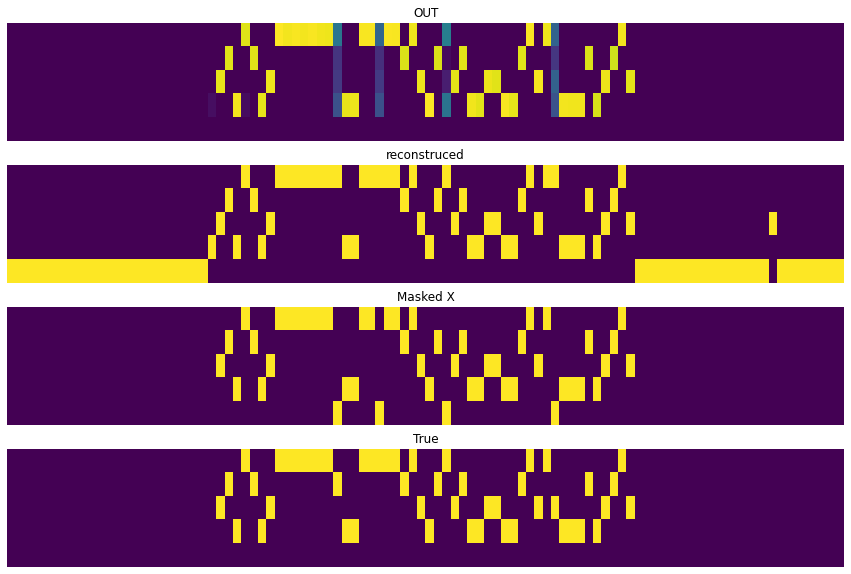

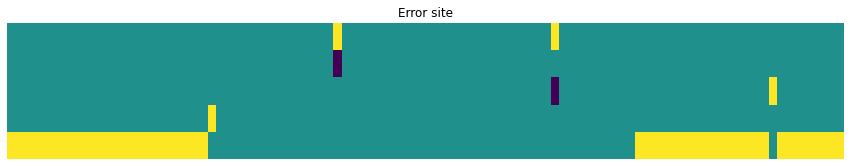

In [92]:
i = next(n_iter)
print("Accuracy {} %".format(model.compute_acc(out[i].unsqueeze(dim=0),X[i].unsqueeze(dim=0),y[i].unsqueeze(dim=0))))
print("i=%d"%i)
visiualize_result(out[i],re_X[i],X[i],y[i])

fig=  plt.figure(figsize=(15,2.5))
ax = fig.gca()
ax.axis("off")
ax.imshow((re_X[i]-y[i]).detach().numpy().T,aspect='auto');
ax.set_title("Error site");

In [402]:
2*99/3

66.0